# Project 4 - Image Warping and Mosaicing

### Dependencies

In [1]:
import cv2
import json
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from matplotlib import image as mpimg


## Shoot and digitize pictures

In [6]:
my_warp_image = plt.imread('../data/IMG_8359.jpeg')

with open('../data/warp_points.json', 'r') as f:
    warped_points = json.load(f)

warped_points_1 = np.array(warped_points["im1Points"])
warped_points_2 = np.array(warped_points["im2Points"])

## Recover homography

In [7]:
# Function to compute the homography matrix
def computeH(im1_pts, im2_pts):
    n = im1_pts.shape[0]
    A = []

    for i in range(n):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]

        # Two rows for each correspondence (one for x', one for y')
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])

    A = np.array(A)
    
    # Solve for h using SVD
    U, S, V = np.linalg.svd(A)
    
    # H is the last column of V (corresponding to the smallest singular value)
    H = V[-1].reshape(3, 3)
    
    # Normalize H to ensure h33 is 1
    H /= H[2, 2]
    
    return H

# Compute the homography matrix
H = computeH(warped_points_1, warped_points_2)

## Warp the Images

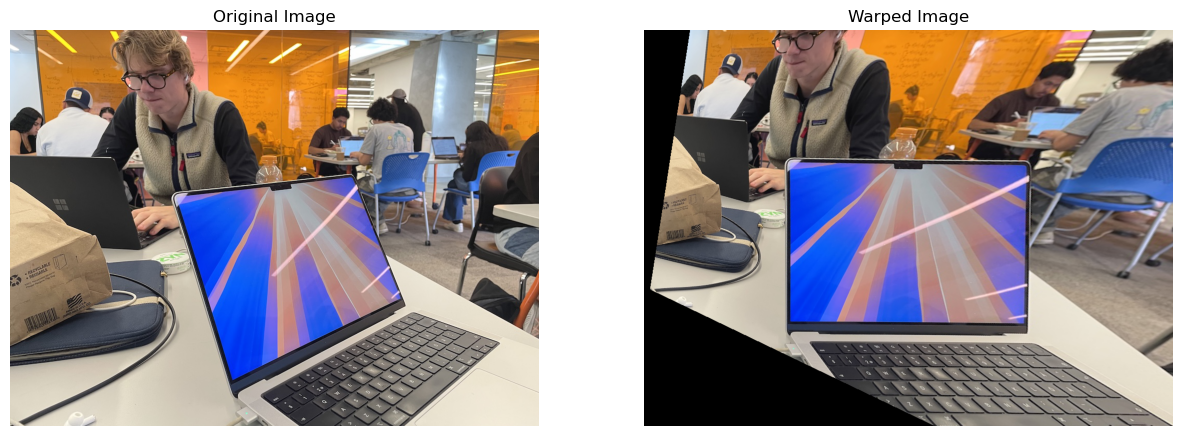

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to apply bilinear interpolation at floating point coordinates
def bilinear_interpolation(im, x, y):
    h, w, c = im.shape

    # Ensure coordinates are within bounds
    if x < 0 or x >= w or y < 0 or y >= h:
        return np.zeros((c,))  # Out of bounds, return black

    # Get the surrounding pixel coordinates
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = min(x1 + 1, w - 1), min(y1 + 1, h - 1)

    # Distances from the point to the surrounding pixel coordinates
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = 1 - dx1, 1 - dy1

    # Interpolating between four surrounding pixels
    top_left = im[y1, x1]
    top_right = im[y1, x2]
    bottom_left = im[y2, x1]
    bottom_right = im[y2, x2]

    top = top_left * dx2 + top_right * dx1
    bottom = bottom_left * dx2 + bottom_right * dx1
    pixel_value = top * dy2 + bottom * dy1

    return pixel_value

# Warp image function
def warpImage(im, H):
    h_out, w_out = im.shape[0], im.shape[1]
    im_warped = np.zeros((h_out, w_out, im.shape[2]), dtype=im.dtype)

    # Inverse of the homography matrix
    H_inv = np.linalg.inv(H)

    # Loop over every pixel in the output image
    for y_out in range(h_out):
        for x_out in range(w_out):
            # Transform the (x_out, y_out) point back to the input image coordinates
            src_pt = np.array([x_out, y_out, 1])
            src_pt = H_inv @ src_pt
            src_pt /= src_pt[2]  # Normalize homogeneous coordinates

            x_src, y_src = src_pt[0], src_pt[1]

            # Get the pixel value at the computed (x_src, y_src) using bilinear interpolation
            im_warped[y_out, x_out] = bilinear_interpolation(im, x_src, y_src)

    return im_warped

# Test the function
# Assuming im1 is the original image and H is the homography matrix you've already computed
im_warped = warpImage(my_warp_image, H)

# Display the result
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(my_warp_image)
plt.title('Original Image')
plt.axis('off')

# Warped image
plt.subplot(1, 2, 2)
plt.imshow(im_warped)
plt.title('Warped Image')
plt.axis('off')

plt.show()

## Blend the Images into Mosaics

In [ ]:
panorama_left = plt.imread('../data/IMG_8357.jpeg')
panorama_right = plt.imread('../data/IMG_8358.jpeg')

# the points are defined in a json file
with open('../data/points_18.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])